<a href="https://colab.research.google.com/github/techperfect/LeetCode/blob/master/CS159_GAN_demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credits to https://blog.paperspace.com/implementing-gans-in-tensorflow/

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

# Defining True Distribution

True distribution: $y = 10 + x^2$

Noise variable: $z$ ~ Uniform$(-1, 1)$

In [ ]:
def get_y(x):
    return 10 + x*x


def sample_data(n=10000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

  
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


# The Generator Network

2 hidden layers, with 16 units in each layer.

Takes in a placeholder for $Z$, a vector of noise variables.

Outputs ordered pairs that mimic data from the true distribution.

In [ ]:
def generator(Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)
    return out

# The Discriminator Network

3 hidden layers, with 16, 16, 2 units in each layer.

Takes in a placeholder for $X$, either real or generated data.

Outputs a logit ($\log \frac{P(1)}{P(0)}$) prediction for the category of $X$.

In [ ]:
def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)
    return out

# Initializations

In [ ]:
# Placeholders for X and Z
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

# Generator and discriminator tensors declaration
G_sample = generator(Z)
r_logits = discriminator(X)
f_logits = discriminator(G_sample,reuse=True)

# Define the loss functions: sigmoid cross entropy
disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

# Define the optimizers: RMSProp Optimizer for both
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step

# Start new tensorflow session
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

# Define training settings
batch_size = 256
n_steps = 10 # number of steps within one epoch

# Sample the true distribution (quadratic)
x_plot = sample_data(n=batch_size)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


# Training

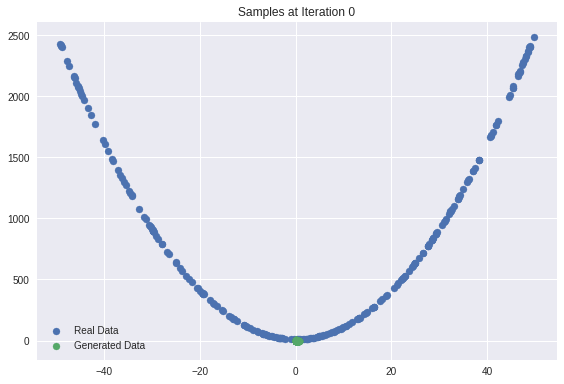

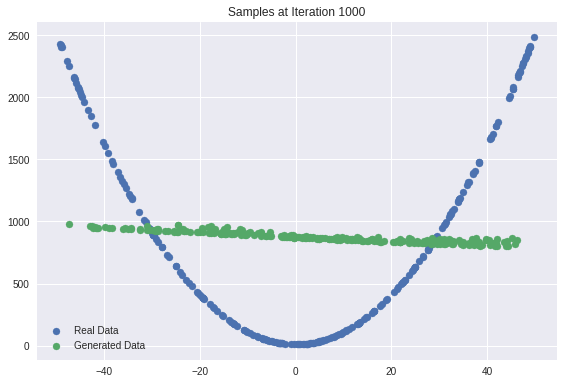

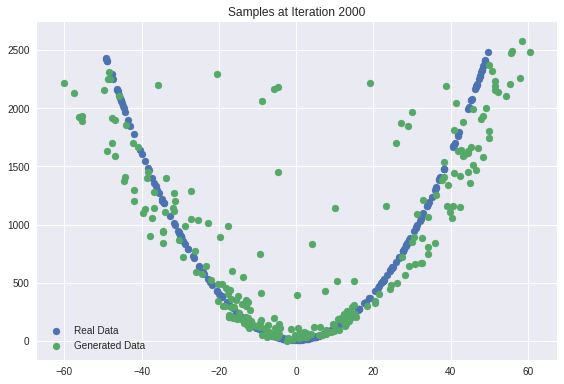

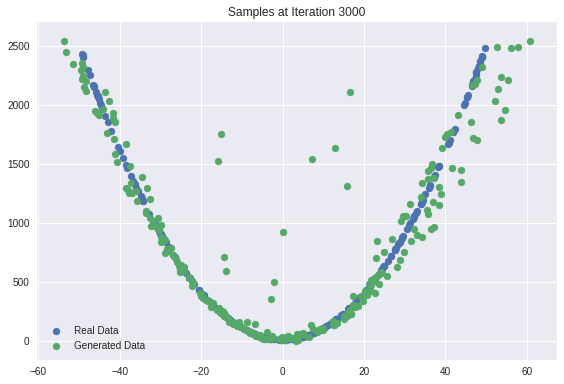

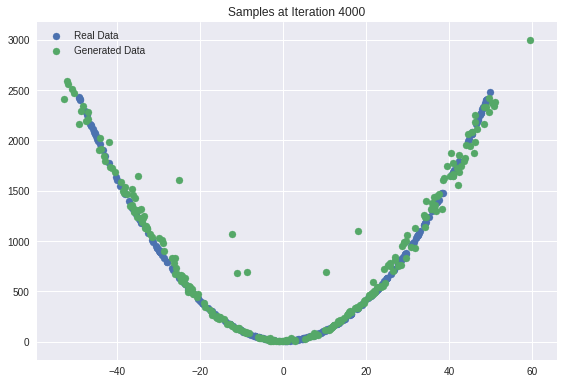

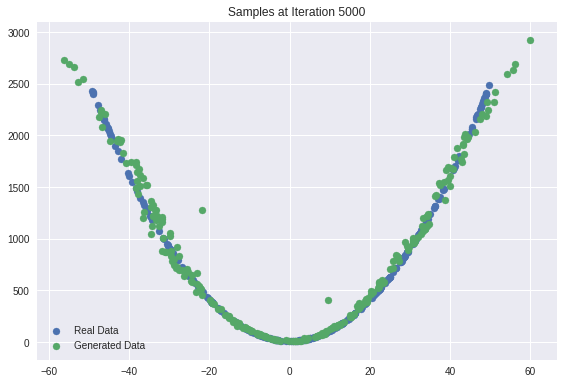

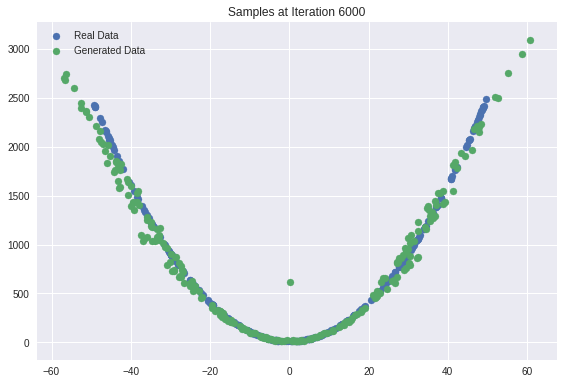

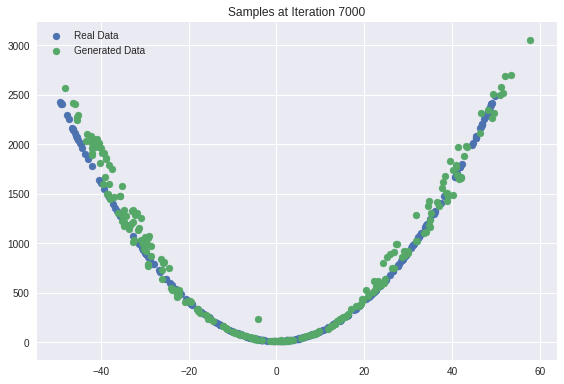

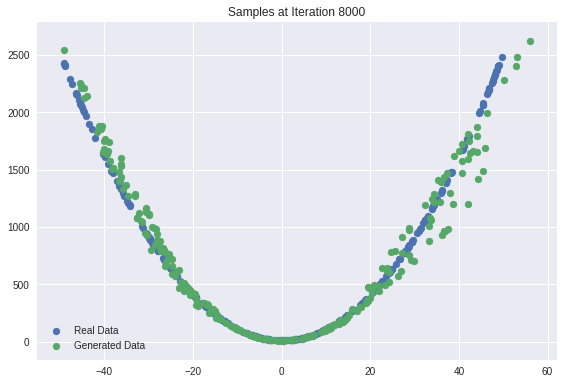

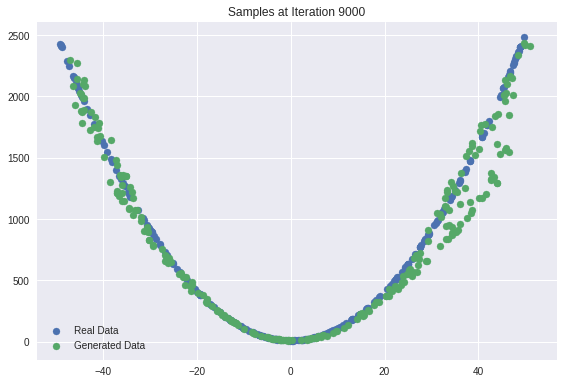

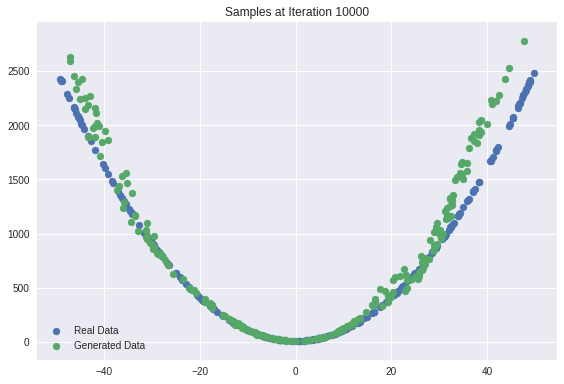

In [ ]:
for i in range(10001):

    for _ in range(n_steps):
        X_batch = sample_data(n=batch_size)
        Z_batch = sample_Z(batch_size, 2)
        # Run the discriminator
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
      
        # Run the generator
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    # Generate data & plot every 1000 epochs
    if i%1000 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.show()
